In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torchvision.transforms as transforms

from RandAugment import RandAugment

from glob import glob

from tqdm.notebook import tqdm

In [2]:
from augs.mix.cutmix2 import cutmix2
from augs.mix.mixup2 import mixup2
from augs.mix.tile import tile

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def get_acc(y_true, y_pred):
    total = y_true.size(0)
    correct = (y_pred == y_true).sum().item()
    return correct / total

def get_acc_at_k(y_true, y_pred, k=2):
    y_true = torch.tensor(y_true) if type(y_true) != torch.Tensor else y_true
    y_pred = torch.tensor(y_pred) if type(y_pred) != torch.Tensor else y_pred
    total = len(y_true)
    y_weights, y_idx = torch.topk(y_true, k=k, dim=-1)
    out_weights, out_idx = torch.topk(y_pred, k=k, dim=-1)
    correct = torch.sum(torch.eq(y_idx, out_idx) * y_weights)
    acc = correct / total
    return acc.item()

In [9]:
def initialize_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight.data, mode='fan_out')
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1)
        module.bias.data.zero_()
    elif isinstance(module, nn.Linear):
        module.bias.data.zero_()


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 remove_first_relu,
                 add_last_bn,
                 preact=False):
        super(BasicBlock, self).__init__()

        self._remove_first_relu = remove_first_relu
        self._add_last_bn = add_last_bn
        self._preact = preact

        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,  # downsample with first conv
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)

        if add_last_bn:
            self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))

    def forward(self, x):
        if self._preact:
            x = F.relu(
                self.bn1(x), inplace=True)  # shortcut after preactivation
            y = self.conv1(x)
        else:
            # preactivation only for residual path
            y = self.bn1(x)
            if not self._remove_first_relu:
                y = F.relu(y, inplace=True)
            y = self.conv1(y)

        y = F.relu(self.bn2(y), inplace=True)
        y = self.conv2(y)

        if self._add_last_bn:
            y = self.bn3(y)

        y += self.shortcut(x)
        return y


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self,
                 in_channels,
                 out_channels,
                 stride,
                 remove_first_relu,
                 add_last_bn,
                 preact=False):
        super(BottleneckBlock, self).__init__()

        self._remove_first_relu = remove_first_relu
        self._add_last_bn = add_last_bn
        self._preact = preact

        bottleneck_channels = out_channels // self.expansion

        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(
            in_channels,
            bottleneck_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        self.conv2 = nn.Conv2d(
            bottleneck_channels,
            bottleneck_channels,
            kernel_size=3,
            stride=stride,  # downsample with 3x3 conv
            padding=1,
            bias=False)
        self.bn3 = nn.BatchNorm2d(bottleneck_channels)
        self.conv3 = nn.Conv2d(
            bottleneck_channels,
            out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)

        if add_last_bn:
            self.bn4 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()  # identity
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))

    def forward(self, x):
        if self._preact:
            x = F.relu(
                self.bn1(x), inplace=True)  # shortcut after preactivation
            y = self.conv1(x)
        else:
            # preactivation only for residual path
            y = self.bn1(x)
            if not self._remove_first_relu:
                y = F.relu(y, inplace=True)
            y = self.conv1(y)

        y = F.relu(self.bn2(y), inplace=True)
        y = self.conv2(y)
        y = F.relu(self.bn3(y), inplace=True)
        y = self.conv3(y)

        if self._add_last_bn:
            y = self.bn4(y)

        y += self.shortcut(x)
        return y

class Network(nn.Module):
    def __init__(self, config):
        super(Network, self).__init__()

        input_shape = config['input_shape']
        n_classes = config['n_classes']

        base_channels = config['base_channels']
        self._remove_first_relu = False
        self._add_last_bn = False
        block_type = config['block_type']
        depth = config['depth']
        preact_stage = [True, True, True]

        assert block_type in ['basic', 'bottleneck']
        if block_type == 'basic':
            block = BasicBlock
            n_blocks_per_stage = (depth - 2) // 6
            assert n_blocks_per_stage * 6 + 2 == depth
        else:
            block = BottleneckBlock
            n_blocks_per_stage = (depth - 2) // 9
            assert n_blocks_per_stage * 9 + 2 == depth

        n_channels = [
            base_channels,
            base_channels * 2 * block.expansion,
            base_channels * 4 * block.expansion,
        ]

        self.conv = nn.Conv2d(
            input_shape[1],
            n_channels[0],
            kernel_size=(3, 3),
            stride=1,
            padding=1,
            bias=False)

        self.stage1 = self._make_stage(
            n_channels[0],
            n_channels[0],
            n_blocks_per_stage,
            block,
            stride=1,
            preact=preact_stage[0])
        self.stage2 = self._make_stage(
            n_channels[0],
            n_channels[1],
            n_blocks_per_stage,
            block,
            stride=2,
            preact=preact_stage[1])
        self.stage3 = self._make_stage(
            n_channels[1],
            n_channels[2],
            n_blocks_per_stage,
            block,
            stride=2,
            preact=preact_stage[2])
        self.bn = nn.BatchNorm2d(n_channels[2])

        # compute conv feature size
        with torch.no_grad():
            self.feature_size = self._forward_conv(
                torch.zeros(*input_shape)).view(-1).shape[0]

        self.fc = nn.Linear(self.feature_size, n_classes)

        # initialize weights
        self.apply(initialize_weights)

    def _make_stage(self, in_channels, out_channels, n_blocks, block, stride,
                    preact):
        stage = nn.Sequential()
        for index in range(n_blocks):
            block_name = 'block{}'.format(index + 1)
            if index == 0:
                stage.add_module(
                    block_name,
                    block(
                        in_channels,
                        out_channels,
                        stride=stride,
                        remove_first_relu=self._remove_first_relu,
                        add_last_bn=self._add_last_bn,
                        preact=preact))
            else:
                stage.add_module(
                    block_name,
                    block(
                        out_channels,
                        out_channels,
                        stride=1,
                        remove_first_relu=self._remove_first_relu,
                        add_last_bn=self._add_last_bn,
                        preact=False))
        return stage

    def _forward_conv(self, x):
        x = self.conv(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = F.relu(
            self.bn(x),
            inplace=True)  # apply BN and ReLU before average pooling
        x = F.adaptive_avg_pool2d(x, output_size=1)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [10]:
def get_logits(model, X, batch_size=8):
    out = []
    for pos in range(0, len(X), batch_size):
        X_ = X[pos:pos + batch_size] 
        logits = model(X_)
        out.append(logits)
    return torch.cat(out).cpu()

In [3]:
def get_dataloader(config):

    test_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    if config['use_basicaug']:
        test_transform.transforms.insert(0, transforms.RandomHorizontalFlip())
        test_transform.transforms.insert(0, transforms.RandomCrop(32, padding=4))

    if config['use_randaug']:
        n = config['randaug_n']
        m = config['randaug_m']
        test_transform.transforms.insert(0, RandAugment(n=2, m=3))

    if config['dataset'] == 'CIFAR10':
        dataset_dir = 'C:/data/CIFAR10'
        _MEAN, _STD = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        test_transform.transforms.insert(
            len(test_transform.transforms), transforms.Normalize(_MEAN, _STD))
        test_dataset = torchvision.datasets.CIFAR10(
            dataset_dir, train=False, transform=test_transform, download=True)
    elif config['dataset'] == 'MNIST':
        dataset_dir = 'C:/data/MNIST'
        _MEAN, _STD = (0.1307,), (0.3081,)
        test_transform.transforms.insert(
            len(test_transform.transforms), transforms.Normalize(_MEAN, _STD))
        test_dataset = torchvision.datasets.MNIST(
            dataset_dir, train=False, transform=test_transform, download=True)
    else:
        raise InputError("dataset not supported...")

    collator = torch.utils.data.dataloader.default_collate
    
    if config['use_mixup2']:
        collator = mixup2.Mixup2Collator(
            alpha=config['alpha'],  
            target_pairs=config['target_pairs'], 
            target_prob=config['target_prob'], 
            num_classes=config['n_classes']
        )
    if config['use_cutmix2']:
        collator = cutmix2.CutMix2Collator(
            alpha=config['alpha'],  
            target_pairs=config['target_pairs'], 
            target_prob=config['target_prob'], 
            resize_prob=config['resize_prob'], 
            num_classes=config['n_classes']
        )
    if config['use_tile']:
        collator = tile.TileCollator(
            num_tiles=config['num_tiles'],  
            target_pairs=config['target_pairs'], 
            target_prob=config['target_prob'], 
            num_classes=config['n_classes']
        )
                
    dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        collate_fn=collator,
        shuffle=True,
        pin_memory=True,
        drop_last=False,
    )
    return dataloader

In [4]:
from torchvision.utils import save_image
from torch.nn.functional import interpolate
import os

In [5]:
num_examples = 100

new_size = (500, 500)

class_names = ('airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck')

for d in ["MNIST"]:                      
    for t in ['ORIG', 'INV', 'Mixup2', 'Cutmix', 'Cutmix2', 'Tile']:
        config = {
            'dataset': d,
            'batch_size': 100,
            'num_workers': 2,
            'use_basicaug': t == 'INV' and d == 'MNIST',
            'use_randaug': t == 'INV' and d != 'MNIST',
            'use_mixup2': t == 'Mixup2',
            'use_cutmix2': 'Cutmix' in t,
            'use_tile': t == 'Tile',
            'randaug_n': 2,
            'randaug_m': 3,
            'alpha': 1.0,
            'target_pairs': [],
            'target_prob': 1.0,
            'resize_prob': 1.0 if t == 'Cutmix2' else 0,
            'n_classes': 10,
            'num_tiles': 4,
        }
        
        dataloader = get_dataloader(config)
        
        img_dir = "imgs/MNIST/" + t
        os.makedirs(img_dir, exist_ok=True)
        
        out = []
        for i in range(num_examples):
            X, y_true = next(iter(dataloader))
            for x, y in zip(X, y_true):
                img_name = os.path.join(img_dir, 'img_' + str(i) + '.png')
                out.append({
                    'img_name': img_name,
                    'label': y.numpy().tolist(),
                })
                x = interpolate(x.unsqueeze(0), new_size, mode='bilinear')
                save_image(x, img_name)
                break

        df = pd.DataFrame(out)
        csv_name = os.path.join(img_dir, t + '_input_label_pairs.csv')
        df.to_csv(csv_name)

C:\Users\Fabrice\AppData\Local\Continuum\anaconda3\envs\python38\lib\site-packages\torch\nn\functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [20]:
# mnist_models = glob('augs/mix/*/*/*/*/*/*.pth')

In [14]:
num_suites = 100
num_tests = 100

datasets = ['MNIST']
trans = ['ORIG', 'INV', 'Mixup2', 'Cutmix', 'Cutmix2', 'Tile']
model_paths = [
    'augs/mix\\cutmix2\\results\\MNIST\\cutmix2\\t0.0_r0.0\\model_state.pth',
    'augs/mix\\mixup2\\results\\MNIST\\mixup2\\t0.0\\model_state.pth',
    'augs/mix\\tile\\results\\MNIST\\tile\\t0.0_n4\\model_state.pth',
]

results = []
for model_path in model_paths:
    
    model = Network({
        'block_type': 'basic',
        'depth': 20,
        'base_channels': 64,
        'input_shape': [1,1,28,28],
        'n_classes': 10}).to(device)
    model.load_state_dict(torch.load(model_path)['state_dict'])
    
    for t in trans:
    
        for d in datasets:

            config = {
                    'dataset': d,
                    'batch_size': num_tests,
                    'num_workers': 2,
                    'use_basicaug': t == 'INV' and d == 'MNIST',
                    'use_randaug': t == 'INV' and d != 'MNIST',
                    'use_mixup2': t == 'Mixup2',
                    'use_cutmix2': 'Cutmix' in t,
                    'use_tile': t == 'Tile',
                    'randaug_n': 2,
                    'randaug_m': 3,
                    'alpha': 1.0,
                    'target_pairs': [],
                    'target_prob': 1.0,
                    'resize_prob': 1.0 if t == 'Cutmix2' else 0,
                    'n_classes': 10,
                    'num_tiles': 4,
                }

            dataloader = get_dataloader(config)
            is_soft_label = False
            if t not in ['ORIG', 'INV']:
                is_soft_label = True

            accs = []
            for _ in tqdm(range(num_suites)):

                    X, y_true = next(iter(dataloader))

                    logits = get_logits(model, X.to(device), batch_size=8)

                    if is_soft_label:
                        acc = get_acc_at_k(y_true, logits, k=2)
                    else:
                        y_pred = logits.argmax(-1)
                        acc = get_acc(y_true, y_pred)

                    # print(acc)

                    accs.append(acc)

            test_acc = sum(accs) / len(accs)

            out = {
                "MODEL_NAME": 'PreAct ResNet',
                "model_path": model_path,
                "dataset": d,
                'trans': t,
                "test_acc": test_acc
            }

            print(out)
            results.append(out)
        
df = pd.DataFrame(results)


{'MODEL_NAME': 'PreAct ResNet', 'model_path': 'augs/mix\\cutmix2\\results\\MNIST\\cutmix2\\t0.0_r0.0\\model_state.pth', 'dataset': 'MNIST', 'trans': 'Cutmix', 'test_acc': 0.6752114106714725}



{'MODEL_NAME': 'PreAct ResNet', 'model_path': 'augs/mix\\mixup2\\results\\MNIST\\mixup2\\t0.0\\model_state.pth', 'dataset': 'MNIST', 'trans': 'Cutmix', 'test_acc': 0.6067962106317282}



{'MODEL_NAME': 'PreAct ResNet', 'model_path': 'augs/mix\\tile\\results\\MNIST\\tile\\t0.0_n4\\model_state.pth', 'dataset': 'MNIST', 'trans': 'Cutmix', 'test_acc': 0.5568723197281361}


In [15]:
df.to_clipboard(excel=True)

In [12]:
df.to_csv('test_models_mnist_results.csv')

In [16]:
import seaborn as sns

sns.set_context("paper")

In [17]:
def show_values_on_bars(axs, values, y_height_addon=0):
    def _show_on_single_plot(ax):        
        for p, v in zip(ax.patches, values):
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + y_height_addon
            if type(v) != str:
                value = ("+" if v > 0 else "") + '{:.0f}%'.format(v)
            else:
                value = v
            ax.text(_x, _y, value, ha="center", size='small') 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

0.9790000000000001


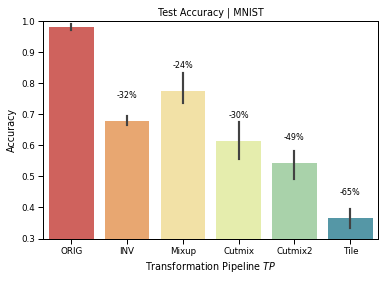

In [19]:
for d in ['MNIST']: 
    
    df = pd.read_csv('test_models_mnist_results.csv')
    
    ds = (df['dataset']==d)
    
    df = df[ds]
    
    ORIG_acc = df[(df['trans']=='ORIG')]['test_acc'].iloc[0]
    print(ORIG_acc)
    df['improv'] = (df['test_acc'] - ORIG_acc) * 100
    
    g = sns.barplot(data=df[df.dataset.str.contains(d)], x='trans', y='test_acc', palette='Spectral')
    g.set_xlabel('Transformation Pipeline $TP$')
    g.set_ylabel('Accuracy')
    g.set_ylim((0.3, 1.00))
    # g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g.set_title('Test Accuracy | ' +  d)
    values = df.improv.tolist()
    values[0] = ""
    show_values_on_bars(g, values, 0.075)
    g.figure.savefig('imgs/test_acc_' + d)
    plt.show()